
Your data is being searched in the frequency range 2.0000012180007416 Hz to  73227.88517867605 Hz

Lowest detection statistic value is:  0.001385351726

 Approximate optimal frequency is:  114.460402352582

 Optimal phase is:  1.731586501979 and optimal frequency is:  228.781065476312


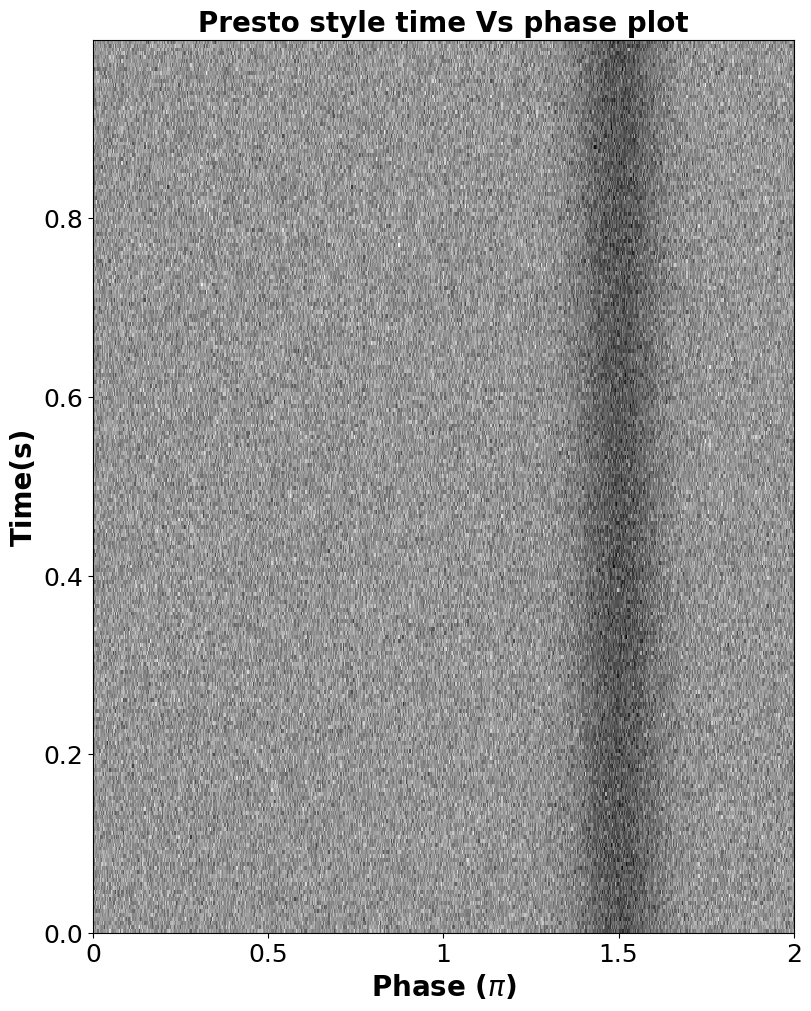

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
import glob
warnings.filterwarnings('ignore')

class DetectionStatisticAnalyzer:
    
    file_list = []
    optimal_parameter = []  
    
    def __init__(self, data_path, save_results):
        self.N_phi = 8
        self.N_w = 512
        self.ref_value = -100
        self.save_results = save_results
        
        """ These lists will be used to store the values calculated by algorithm """
        
        self.phase_list = []
        self.freq_list = []
        self.det_stat_list = []

        self.duty_cycle = 0.1
        self.acceleration = 0
        
        df = pd.read_csv(data_path, delimiter='    ')
        self.time = np.array(df['time_sec'])
        self.datastream = np.array(df['intensity'])
        self.sample_time = df['time_sec'][1] - df['time_sec'][0]     # Time resolution of the data
        
        ''' Lower and upper frequency bound are calculated based on data '''
        self.low_limit_freq = 2/(max(df['time_sec']))
        self.up_limit_freq = 1/(2*self.sample_time)

        """
        Removing pre-existing files in the target folder so that new files won't get confused with old files. 
        """
    
        files_removing = glob.glob(save_results + '/*')
        for files in files_removing:
            os.remove(files)

        print('\nYour data is being searched in the frequency range',self.low_limit_freq, 'Hz to ', self.up_limit_freq, 'Hz')
        
    def pulse_phase(self, p0, t, w0):    
        """
        Calculates and returns pulse phase at any given time 't' when acceleration 'a', initial 
        phase 'p0' and angular frequency 'w0' are known.
        """
        phase = np.array(p0 + 2*np.pi*w0*t + 0.5 * self.acceleration * t ** 2)
        return phase

    def von_mises_profile(self, phase_angle):
        """
        Calculates von Mises profile based on concentration function K.
        For the value of pulse_phase it makes a call from pulse_phase function defined above.
        """
        k = (np.log(2)) / (2 * (np.sin((np.pi * self.duty_cycle) / 2)) ** 2)
        y = np.exp(-2*k*(np.sin(phase_angle/2))**2)
        return y
    
    def detection_statistic(self, phaseangle):
        """
        Calculates the detection statistic based on eqn 5 in Smith K, 2016 paper. I_k is von_mises profile calculated for 
        various phase angles. Phase angle itself is calculated from pulse_phase function for the time series.
        """
        I_k = self.von_mises_profile(phaseangle)
        eta_neg_sqr = 1 / (self.sample_time * (np.sum(I_k ** 2)))                          # Gives a noise parameter
        det_stat = eta_neg_sqr * self.sample_time * (np.sum(self.datastream * I_k))
        return det_stat
        
    def ComputeDetection(self, numof_phase, numof_freq, low_freqlimit, high_freqlimit):
        
        ''' Will do the calculation for detection statics in a matrix of shape given by numof_phase and numof_freq values. 
        Calculation will be done in the range of frequencies given by low_freqlimit and high_freqlimit. We don't specify range 
        for phase because we search over all the the pahse space of 0 to 2*pi. Detection statistics will be stored in a csv file
        for future reference in the folder specified as target path. '''
        
        self.numof_phase = numof_phase
        self.numof_freq = numof_freq
        rest_phase = np.linspace(0, np.pi*2, numof_phase)                 # Creating a grid of phase and frequency search space
        freq = np.linspace(low_freqlimit, high_freqlimit, numof_freq)
                    
        for ind1 in np.arange(len(rest_phase)):
            p0_val = rest_phase[ind1]
            for ind2 in np.arange(len(freq)):
                freq_value = freq[ind2]
                self.phase_list.append(round(p0_val, 12))
                self.freq_list.append(round(freq_value, 12))
                phase_val = self.pulse_phase(p0_val, self.time, freq_value)
                det_stat_val = self.detection_statistic(phase_val)
                self.det_stat_list.append(round(det_stat_val, 12))
                
        data = {'Phase': self.phase_list, 'Frequency': self.freq_list, 'Detection Statistic': self.det_stat_list}
        phasefreqdf = pd.DataFrame(data, index=np.arange(len(self.det_stat_list)))                    
        phasefreqdf.to_csv(self.save_results + '/L_freq = {}__U_freq = {}__N_phase = {}_and_N_freq = {}'.format(low_freqlimit, high_freqlimit, numof_phase, numof_freq), sep= '\t', mode = 'w', columns=['Phase','Frequency','Detection Statistic'], header = ['Phase','Frequency','Detection Statistic'], index=False)
        self.plot_detection_statistic(numof_phase, numof_freq, low_freqlimit, high_freqlimit, phasefreqdf)

        ''' Section of the code below is used only for intense search after range of frequency to do intense search has been
        identified. User supplies the numof_freq  and will be power of 2 and higher than initial search grid number of freq.'''
        
        if numof_freq == 8192:
            det_max = max(phasefreqdf['Detection Statistic'])
            optimal_query = phasefreqdf.query('`Detection Statistic`==@det_max')
            optimal_phase = max(optimal_query['Phase'])
            DetectionStatisticAnalyzer.optimal_parameter.append(optimal_phase)
            optimal_frequency = max(optimal_query['Frequency'])
            DetectionStatisticAnalyzer.optimal_parameter.append(optimal_frequency)
            print('\n Optimal phase is: ',optimal_phase, 'and optimal frequency is: ', optimal_frequency)

    def run_detection(self):
        ''' This section is like an actual manufacturing plant. First while loop part will perform a low key search and combine 
        all the results from this low key search at serveral different frequency range. Next, we make a call for several methods
        as necessary  to get diagnostic plots and do more intense search after finding intial approximate maximum detection.  '''
        
        self.low_freq = round(self.low_limit_freq, 12)
        self.high_freq = 10*self.low_freq
    
        while self.high_freq <= (self.up_limit_freq)/2:
                rest_phase = np.linspace(0, np.pi*2, self.N_phi)
                freq = np.linspace(self.low_freq, self.high_freq, self.N_w)
                self.ComputeDetection(self.N_phi, self.N_w, self.low_freq, self.high_freq)
                self.phase_list.clear()
                self.freq_list.clear()
                self.det_stat_list.clear() 
                DetectionStatisticAnalyzer.file_list.append('L_freq = {}__U_freq = {}__N_phase = {}_and_N_freq = {}'.format(self.low_freq, self.high_freq, self.N_phi, self.N_w))
                self.low_freq = round(self.high_freq, 12) + 1e-2
                self.high_freq = 10*self.low_freq
            
        self.CombinedDataFrame()
        self.MaxvaluePlot()
        #These arguments below can be manually fine tuned to improve the results.
        self.ComputeDetection(128, 8192, 0.1*self.optimal_freq, 10*self.optimal_freq)  
        self.DatavsModelGraph()
        self.PrestoStylePlot()
        
    def plot_detection_statistic(self, N_phase, N_freq, l_freq, h_freq, phasefreq_df):

        ''' Creates a color mesh plot for matrix of phase and frequency values calculated in ComputeDetection method above.
        Detection statistic will be color coded. '''
        
        fig, phasefreqmap = plt.subplots(figsize=(15, 10), layout='constrained')
        X = np.linspace(l_freq, h_freq, N_freq + 1)
        Y = np.linspace(0, 2*np.pi, N_phase + 1)
        Z = np.array(phasefreq_df['Detection Statistic']).reshape(N_phase, N_freq)
        pcm = phasefreqmap.pcolormesh(X, Y, Z, vmin=Z.min(), vmax=Z.max())
        phasefreqmap.set_xlabel('Frequency(Hz)', fontweight='bold', fontsize=20)
        phasefreqmap.set_ylabel('Phase', fontweight='bold', fontsize=20)
        phasefreqmap.yaxis.set_tick_params(labelsize=20)
        phasefreqmap.xaxis.set_tick_params(labelsize=20)
        phasefreqmap.set_title('Detection statistic for N_phase = {} and N_freq = {} combination'.format(N_phase, N_freq), fontweight='bold', fontsize=20)
        fig.colorbar(pcm, ax=phasefreqmap)
        plt.savefig(self.save_results + '/L_freq = {}__U_freq = {}__N_phase = {}_and_N_freq = {}.pdf'.format(l_freq, h_freq, N_phase, N_freq))  # Only if you want to save your figure.
        plt.close()
    
    def CombinedDataFrame(self):

        ''' This method will combine detection statistics data calculated for different frequency ranges into one concatenated
        file which will be used to create overall detection statistic vs frequency plot.'''
        
        fileList = DetectionStatisticAnalyzer.file_list
        for k in range(len(fileList)):
            file_path = self.save_results + fileList[k]
            df = pd.read_csv(file_path, delimiter = '\t')
            
            if k == 0:
                df_whole = df
            else:
                df_whole = pd.concat([df_whole, df], ignore_index=True)
                
        df_max = df_whole[df_whole['Detection Statistic'] >= self.ref_value]       
        df_max.to_csv(self.save_results +'detection_val'+ str(self.ref_value), sep= '\t', mode = 'w', columns=['Phase','Frequency','Detection Statistic'], header = ['Phase','Frequency','Detection Statistic'], index=False)
        self.df_max = df_max
        self.MaxvaluePlot()
        max_det_value = max(df_max['Detection Statistic'])
        lowest_det_value = min(df_whole['Detection Statistic'])
        optimal_df = df_max.query('`Detection Statistic`==@max_det_value')
        self.optimal_freq = max(optimal_df['Frequency'])
        print('\nLowest detection statistic value is: ', lowest_det_value)
        print('\n Approximate optimal frequency is: ', self.optimal_freq)
        
    def MaxvaluePlot(self):

        ''' Creates a plot for combined file with detection statistics calculated for all the frequency range. This plot can
        be visually inspected to see what is the frequency range to look for to do an intensive search. So, this plot will 
        basically guide us narrow down our search to particular frequency range. '''
        
        fig, ax = plt.subplots(figsize=(12, 10), layout='constrained')
        self.detstat = self.df_max['Detection Statistic']
        self.freq = self.df_max['Frequency']
        ax.semilogx(self.freq, self.detstat)
        ax.set_xlabel('Frequency Range', fontweight = 'bold', size = 20)
        ax.set_ylabel('Detection Statistic', fontweight = 'bold', size = 20)
        ax.set_title('Detection statistics plot for sim_pulse_2 data' , fontweight = 'bold', size = 20)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        plt.savefig(self.save_results + 'det_stat_plot.pdf')
        plt.close()

    def DatavsModelGraph(self):

        ''' Creates a plot of model overlaid on data to visually inspect if the optimal values of phase and frequency calculated
        by the algorithm is a good fit. '''
        
        K_parameter = 14.162195                          #concentration parameter for duty cycle = 0.1
        timestamps = self.time
        self.phase_value = self.optimal_parameter[0]
        self.freq_value = self.optimal_parameter[1]	
        phi = self.phase_value + 2*np.pi*self.freq_value*timestamps
        model = np.exp(-2*K_parameter*(np.sin(phi/2))**2)

        n = 5    # Some random number representing number of  pulse we want to visualize
        x1 = timestamps[1000*n:1000*(n + 3)]
        y1 = self.datastream[1000*n:1000*(n + 3)]
        y2 = model[1000*n:1000*(n + 3)]
        
        fig, DataVsModel = plt.subplots(figsize = (15, 10))
        DataVsModel.plot(x1,y1, color = 'r') 
        DataVsModel.plot(x1,y2,  color = 'b')  
        DataVsModel.set_xlabel('Time', fontweight = 'bold', fontsize = 14)
        DataVsModel.set_ylabel('Intensity', fontweight = 'bold', fontsize = 14)
        DataVsModel.legend(['data','model'], loc = 'upper right', fontsize = 15)
        plt.savefig(self.save_results + 'DataVsModel.pdf')
        plt.close()

    def PrestoStylePlot(self):

        ''' Another visual diagnostic plot to check if our calculated values of optimal phase and frequency are precise.'''
        
        freq_true = self.optimal_parameter[1]                        # Optimal frequency calculated by algorithm
        time_period = 1/freq_true                                    # Timeperiod of a single pulse cycle
        delta_time = self.sample_time                                # Time resolution of timeseries data
        bin_size = int(time_period/delta_time)                       # Chunk size of timeseries to take as one bin
        total_num_datapoints = len(self.datastream)                  # Total number of timestamps/datapoints
        num_of_bins = int(total_num_datapoints/(bin_size))           # Integer number of bins to take out of total datapoints
        intensity_cutoff = self.datastream[0:bin_size*num_of_bins]   # Range of only intensity data points to inclue
        data_timelength = max(self.time)      
        
        fig, prestoplot2 = plt.subplots(figsize=(8, 10), layout='constrained')
        X_phase = np.linspace(0, 2*np.pi, bin_size + 1)
        Y_time = np.linspace(0, data_timelength, num_of_bins + 1) 
        Z_intensity = np.array(intensity_cutoff).reshape(num_of_bins, bin_size)
        pcm = prestoplot2.pcolormesh(X_phase, Y_time, Z_intensity, cmap=plt.cm.gray_r, vmin=Z_intensity.min(), vmax=Z_intensity.max())
        prestoplot2.set_xlabel('Phase ($\pi$)', fontweight='bold', fontsize=20)
        prestoplot2.set_ylabel('Time(s)', fontweight='bold', fontsize=20)
        prestoplot2.yaxis.set_tick_params(labelsize=18)
        prestoplot2.xaxis.set_tick_params(labelsize=18)
        prestoplot2.set_xticks([0, 1.570, 3.141, 4.712, 6.283], [0,0.5,1,1.5,2], minor = False)
        prestoplot2.set_title('Presto style time Vs phase plot', fontweight='bold', fontsize=20)
        plt.savefig(self.save_results + 'prestoStylePlot.pdf')  
        


det_stat = DetectionStatisticAnalyzer(data_path='/home/ak/research/emmanuel/proj_algorithm/sim_pulse_02_updated.txt', save_results = '/home/ak/research/emmanuel/proj_algorithm/code_smoothening/data2/')
det_stat.run_detection()